# Distributions and Hypothesis testing

What distribution should the hourly counts follow?
This is important for the following reasons.
* General understanding of the data.
* Building regression models for the count data.

What distributions should this follow? I think the key is the name *count* data.
This should push us towards Poisson distributions, but...
* This is a real world example and we might not encounter Poisson statistics exactly. This is OK we can handle this with a negative binomial distribution.
* At busy times when the count is *high* our Poisson distribution, we might get away with a normal distribution.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import ipywidgets as widgets
from IPython.display import display, clear_output,HTML, set_matplotlib_formats
import matplotlib.pyplot as plt

from IPython.core.display import Javascript

import tqdm.notebook as tqdm

from PedestrianDataImporter import getHourlyCounts
from Imputation import repairRepeatedMidnightStamps

In [2]:
# Also disable the scroll. I just don't like it
def disable_scroll():
    display(Javascript("""
        IPython.OutputArea.prototype._should_scroll = function(lines) {
            return false;
        }
    """))

disable_scroll()

<IPython.core.display.Javascript object>

## Data importing and some manipulations

Lets import the Melbourne data. No need for any fancy pivotting here.
But we are interested in the hours and we may be interested in the day of the week.

In [3]:
df_counts,df_locations = getHourlyCounts['Melbourne']()
df_counts = repairRepeatedMidnightStamps(df_counts)

# cut = (df_counts['DateTime'] > datetime.datetime(2018,1,1) ) & (df_counts['DateTime'] < datetime.datetime(2020,1,1) ) 
# Maybe don't cut this. Just ignore the missing data for now.
# %%

df_counts['Hour']      = df_counts['DateTime'].dt.hour
df_counts['DayOfWeek'] = df_counts['DateTime'].dt.day_name()
# %%

df_agg = df_counts.groupby(['Hour', 'LocationName']).agg(
    Mean_HourlyCount=('HourlyCount', 'mean'),
    Variance_HourlyCount=('HourlyCount', 'var'),
    HourlyCounts=('HourlyCount', list)
).reset_index()


Loading Melbourne_stored.pkl


## Visual inspection of the count distributions and their distributions

Before we start diving head first into hypothesis testing, let's perform some inspections of the distribution and compare them visually. Lets plot a histogram of the observed data vs the probability distribution, with parameters estimated from the observed data

The distributions on the table are
* **Normal distribution**: Need to specify mean and standard deviation
* **Poission**: Need to specify mean
* **Negative Bin**: Need to specify mean and *dispersion*

In [4]:
distributions = {
        "Normal": "norm",
        "Poisson": "poisson",
        "Negative Binomial": "nbinom"
    }

Lets take an hour which we expect to be busy (12PM) and a hour which we expect to not be so busy.



In [5]:
data_0 = df_agg.loc[ (df_agg["LocationName"] == "231 Bourke St")
                    & (df_agg['Hour'] == 0)]['HourlyCounts'].values[0]
                    
data_12 = df_agg.loc[ (df_agg["LocationName"] == "231 Bourke St")
                    & (df_agg['Hour'] == 12)]['HourlyCounts'].values[0]

In [6]:
def plot_histograms(data, axs, distributions):
    """
    Plot histograms with overlaid theoretical distribution curves.

    Parameters:
    - data: list or numpy array of data points
    - axs: array of axis objects of shape (len(distributions),)
    - distributions: dictionary of distribution names and their corresponding scipy names
    """
    data = np.array(data)
    x = np.linspace(min(data), max(data), 1000)
    
    for i, (name, dist_name) in enumerate(distributions.items()):
        axs[i].hist(data, bins=30, density=True, alpha=0.6, label="Observed Data")
        
        if dist_name == "norm":
            mu = np.mean(data)
            sigma = np.std(data)
            pdf = stats.norm.pdf(x, mu, sigma)
        elif dist_name == "poisson":
            lambda_param = np.mean(data)
            pdf = stats.poisson.pmf(np.round(x), lambda_param)
        else:  # nbinom
            mean = np.mean(data)
            var = np.var(data)
            p = mean / var
            n = mean * p / (1 - p)
            pdf = stats.nbinom.pmf(np.round(x), n, p)
            
        axs[i].plot(x, pdf, 'r-', label=f"Theoretical {name} Distribution")
        axs[i].set_title(f"Data vs. {name} Distribution")
        axs[i].legend()

Lets plot the 0 am data on the left and 12am data on the right.
I see the following things:
* A normal distribution is not the *correct* way to model the data.
    * At 0AM is definitely doesn't describe the data.
    * The left tail of the distribution lies *out-of-domain* for pedestrian counts. You can't count a negative number of people in a space
* A Poisson distribution is also not the *correct* way to model the data.
    * It just doesn't fit the distribution.
* A Negative Binomial distribution, might just be the way forward.
    * It lies in the correct domain. The count is always positive.
    * It looks like it describes the data well.

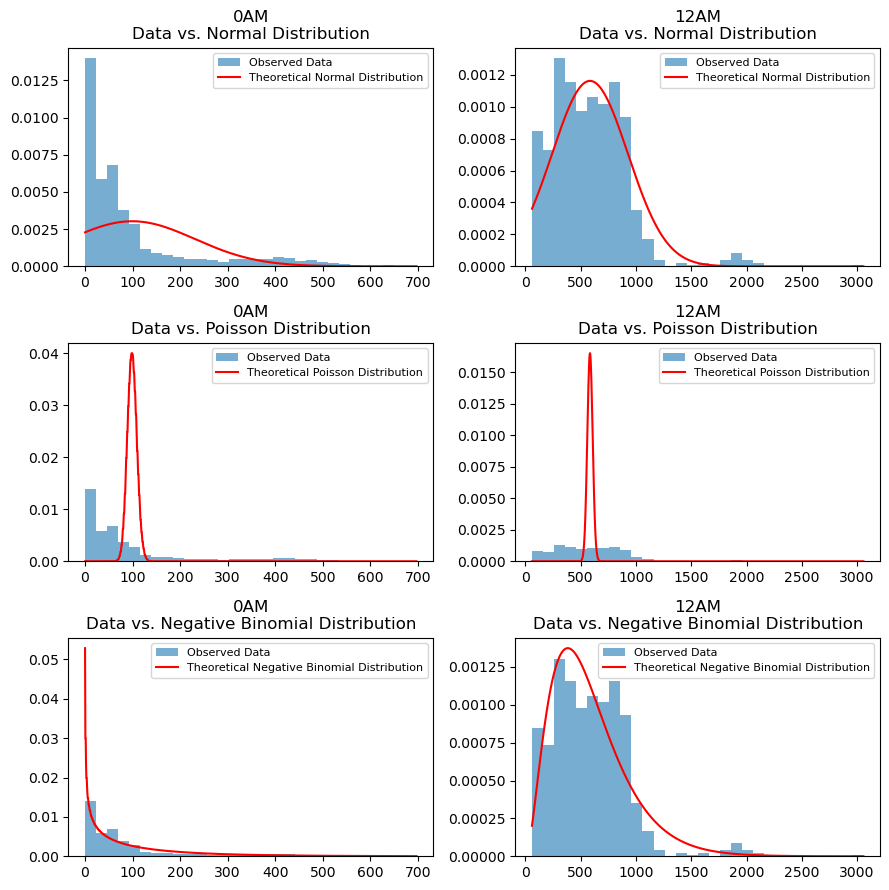

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(9, 9))
plot_histograms(data_0,  axs[:,0], distributions)
plot_histograms(data_12, axs[:,1], distributions)
for ax in axs[:,0]:
    ax.set_title(f"0AM\n{ax.get_title()}")
for ax in axs[:,1]:
    ax.set_title(f"12AM\n{ax.get_title()}")
for ax in axs.flatten():
    ax.legend(loc='upper right', fontsize='8')
plt.tight_layout()
plt.show()

### Going deeper. Q-Q and P-P plots.

Having visually inspected a few distributions, lets get slightly more sophiscated in the way we compare the distributions.

#### P-P (Probability-Probability) Plots:

A P-P plot is a graphical method for comparing two probability distributions by plotting their cumulative probabilities against each other. When assessing the fit of your data to a theoretical distribution, the cumulative probabilities of your data are plotted against the cumulative probabilities of the theoretical distribution.

What you see on a P-P plot:
* X-axis: Theoretical cumulative probabilities from the specified distribution.
* Y-axis: Observed cumulative probabilities from your data.

How to interpret a P-P plot:
Perfect Fit: If your data perfectly follows the specified distribution, the points on the P-P plot will fall along the 45-degree line. This line is also known as the line of equality, where the observed and expected cumulative probabilities are the same.

Deviations from the Line:
* If the points deviate from the 45-degree line, it indicates that your data may not follow the specified distribution.
* Points below the line suggest that your data is more dispersed than the theoretical distribution in that region.
* Points above the line suggest that your data is less dispersed than the theoretical distribution in that region.
* S-Shaped Curve: An S-shaped curve indicates that the tails of your data distribution are lighter than the tails of the theoretical distribution.
* Inverted S-Shaped Curve: An inverted S-shaped curve indicates that the tails of your data distribution are heavier than the tails of the theoretical distribution.

#### Q-Q (Quantile-Quantile) Plots
What you see on a Q-Q plot:
* X-axis: Theoretical quantiles from the specified distribution.
* Y-axis: Observed quantiles from your data.

How to interpret a Q-Q plot:
Perfect Fit: If your data perfectly follows the specified distribution, the points on the Q-Q plot will fall along a straight line. This line is not necessarily the 45-degree line, especially if the scales of the two distributions are different.

Deviations from the Line:
* If the points deviate from the straight line, it indicates that your data may not follow the specified distribution.
* Points below the line suggest that your data has lighter tails than the theoretical distribution in that region.
* Points above the line suggest that your data has heavier tails than the theoretical distribution in that region.
* S-Shaped Curve: An S-shaped curve indicates that your data might be more spread out than the theoretical distribution in the center but less so in the tails.
* Inverted S-Shaped Curve: An inverted S-shaped curve indicates the opposite: your data might be less spread out than the theoretical distribution in the center but more so in the tails.

In summary
* **P-P plots** emphasize the center of the distribution more than the tails.
* **Q-Q plots** emphasize the tails of the distribution more than the center.

In [8]:
def plot_qq_pp(data, axs, distributions):
    """
    Plot Q-Q and P-P plots for given distributions.

    Parameters:
    - data: list or numpy array of data points
    - axs: 2D array of axis objects of shape (len(distributions), 2)
    - distributions: dictionary of distribution names and their corresponding scipy names
    """
    data = np.array(data)
    
    for i, (name, dist_name) in enumerate(distributions.items()):
        # Parameter estimation
        if dist_name == "nbinom":
            mean = np.mean(data)
            var = np.var(data)
            p = mean / var
            n = mean * p / (1 - p)
            params = (n, p)
        elif dist_name == "poisson":
            params = (np.mean(data), )
        else:
            params = None
        
        # Q-Q plot
        if params:
            stats.probplot(data, dist=dist_name, sparams=params, plot=axs[i, 0])
        else:
            stats.probplot(data, dist=dist_name, plot=axs[i, 0])
        axs[i, 0].set_title(f"Q-Q Plot for {name} Distribution")
        
        # P-P plot
        obs_sorted = np.sort(data)
        cdf_obs = np.arange(1, len(data) + 1) / len(data)
        if dist_name == "norm":
            cdf_theoretical = getattr(stats, dist_name).cdf(obs_sorted, loc=np.mean(data), scale=np.std(data))
        else:
            cdf_theoretical = getattr(stats, dist_name).cdf(obs_sorted, *params if params else [])
        axs[i, 1].plot(cdf_theoretical, cdf_obs, 'o')
        axs[i, 1].plot([0, 1], [0, 1], 'r--')
        axs[i, 1].set_title(f"P-P Plot for {name} Distribution")
        axs[i, 1].set_xlabel("Theoretical CDF")
        axs[i, 1].set_ylabel("Observed CDF")
        

Lets plot some of these and walk through them. First the 0AM data.
Each row has the Q-Q, P-P and the histogram / theoretical curve for each distribution.

Its easiest I think to start with the Poisson distribution.
* We can see from the histogram that the data is more spread out than the theoretical distribution.
* We see this reflected in the P-P plot. The line steepily rise when the theoretical CDF is zero, we have made observations when the theoretical CDF said there should be none, similarly at the other end.

Now look at the Normal distribution:
* In this histogram we actually see two peaks!
* The P-P plot looks pretty good, its mostly lying along the diagonal. It is below the line on the left, because we don't have an observations of negative counts! It is above the line on the right, because we have this small second peak in the histogram.
* The quantiles here are *standard deviations*. Below -2 sigma, we have no/very few observations. This makes the curve flatten in this region. Above 2 sigma, we have the small anomaly and this makes the Q-Q curve rise above the line.

Last look at the Negative Binomial:
* The histogram fits a lot better, as we have seen before.
* The P-P plot looks good mostly along the diagonal.
* The Q-Q plot looks a lot like the normal one, slightly shifted to the left. This makes sense as the peak of the Negative Binomial distribution has also been shifted to the left.

In this example we have a **busy** period, it is not surprising that the Normal distribution and the Negative Binomial appear very similar for large counts. (See 02b Poisson distributions, Negative Binomial and Normal Distributions.) But we should strongly lean towards the Negative-Binomial distributions due to the *domain* that they work in. We can't have negative counts so we shouldn't try to fit to a model which expects them!

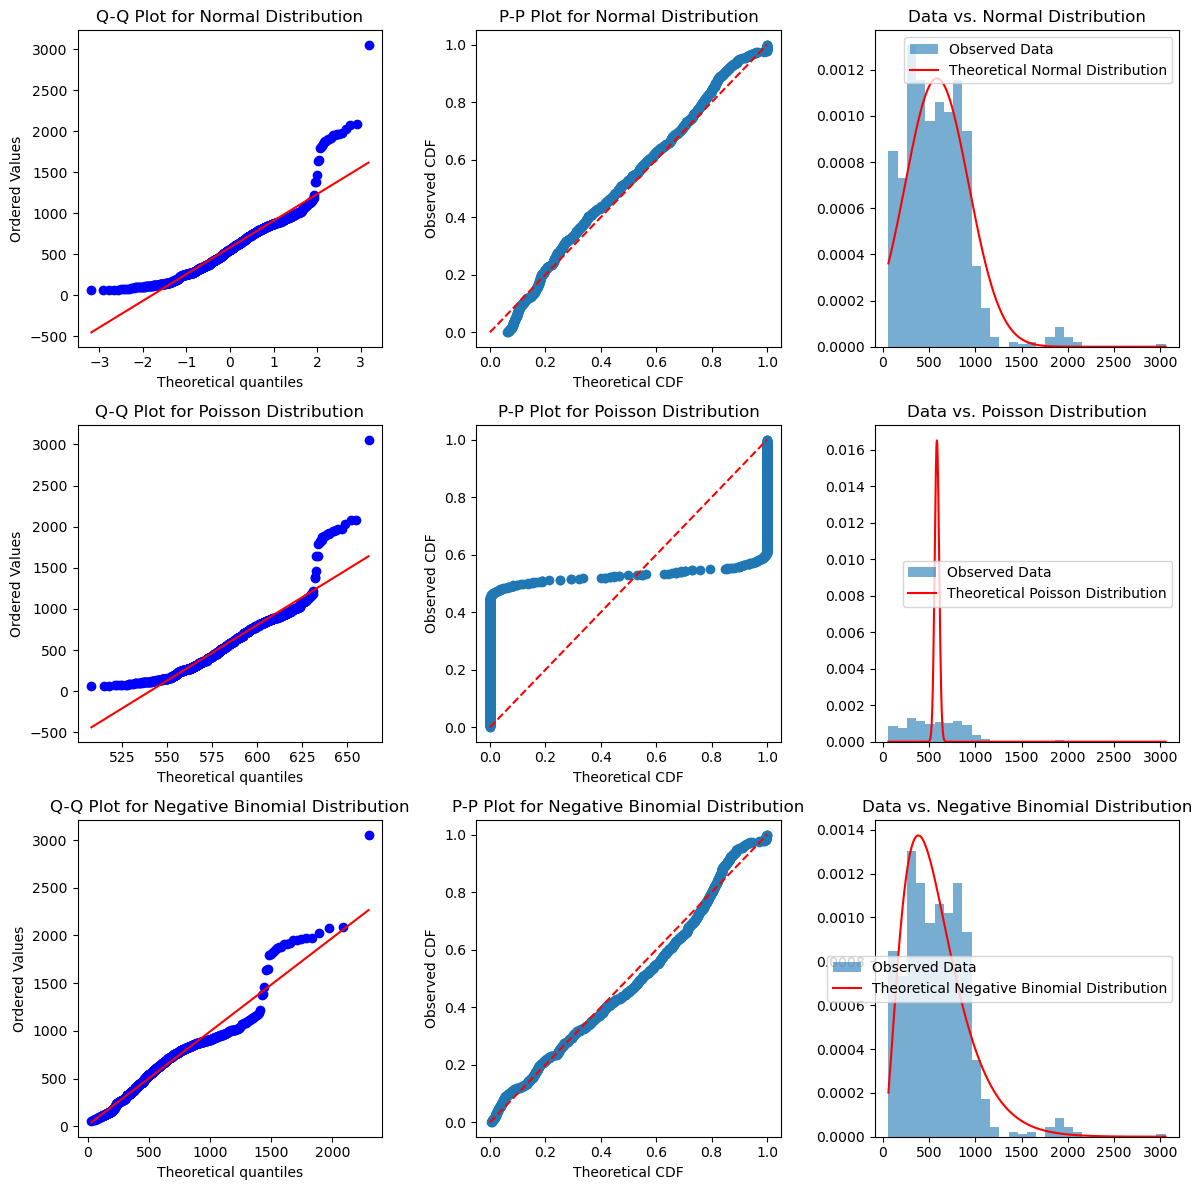

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
plot_qq_pp(data_12, axs[:,0:2], distributions)
plot_histograms(data_12, axs[:,2], distributions)
plt.tight_layout()
plt.show()

Now lets turn and look at the 0AM data. Here we have very few counts, so that we are tending more towards Poisson statistics.
I won't walk through all the plots, the key thing here is that the Negative Binomial gives the best description of the data. The P-P follows the line closely. The Q-Q plot shows that the right tail of the distribution is lower than expected.

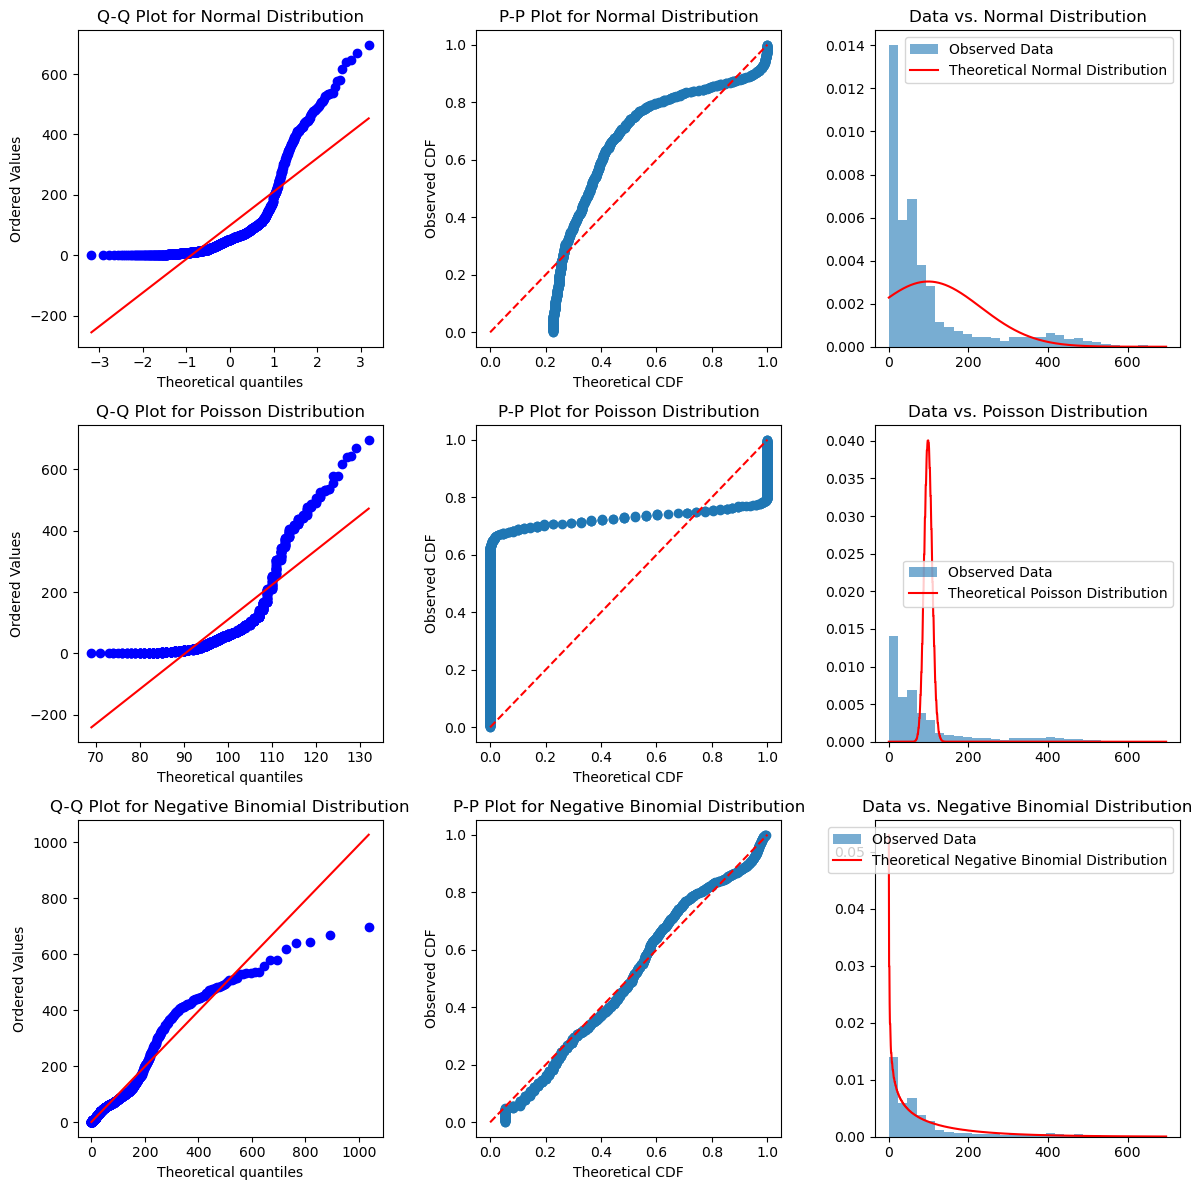

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
plot_qq_pp(data_0, axs[:,0:2], distributions)
plot_histograms(data_0, axs[:,2], distributions)
plt.tight_layout()
plt.show()

### Exploring the different locations and times

Lets create a nice interface for those plots so that we can explore the data further

Dropdown(description='Location:', index=9, options=('231 Bourke St', 'Alfred Place', 'Australia on Collins', '…

Dropdown(description='Hour:', index=3, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, …

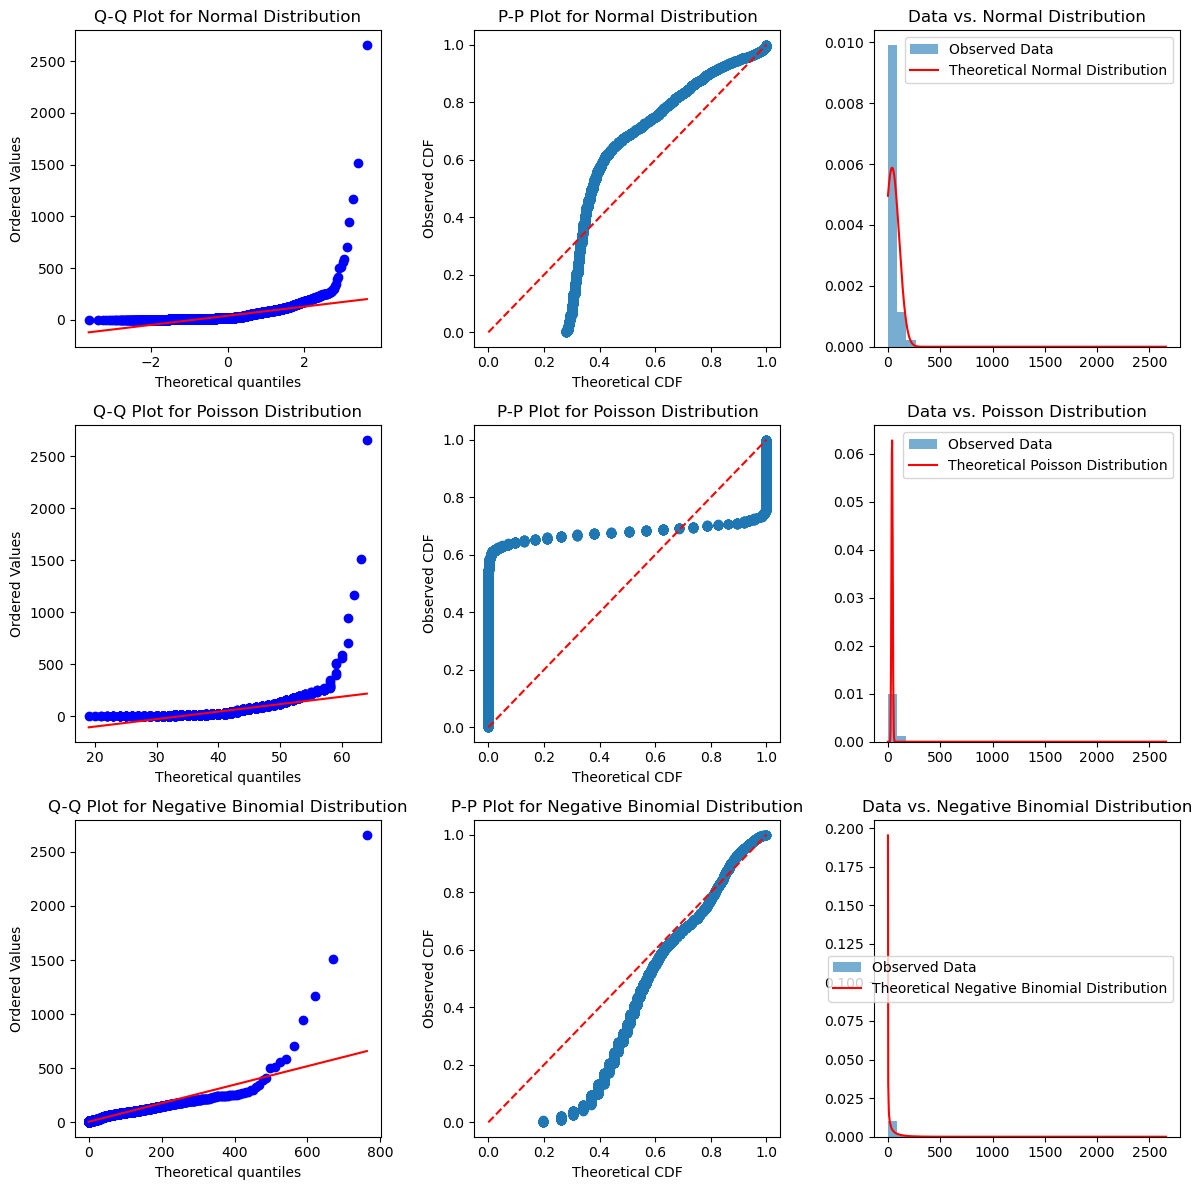

In [11]:
# Create dropdowns for LocationName and Hour
location_dropdown = widgets.Dropdown(
    options=df_agg['LocationName'].unique(),
    description='Location:',
    disabled=False,
)

hour_dropdown = widgets.Dropdown(
    options=[],
    description='Hour:',
    disabled=False,
)

# Update hour dropdown based on selected location
def update_hour_dropdown(change):
    selected_location = change['new']
    available_hours = sorted(df_agg[df_agg['LocationName'] == selected_location]['Hour'].unique())
    hour_dropdown.options = available_hours
    if available_hours:
        hour_dropdown.value = available_hours[0]

location_dropdown.observe(update_hour_dropdown, names='value')

# Display plots based on dropdown selections
def display_plots(change):
    clear_output(wait=True)
    display(location_dropdown, hour_dropdown)
    
    selected_location = location_dropdown.value
    selected_hour = hour_dropdown.value
    data = df_agg[(df_agg['LocationName'] == selected_location) & (df_agg['Hour'] == selected_hour)]['HourlyCounts'].values[0]
    
    # Updated plot structure
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    plot_qq_pp(data, axs[:,0:2], distributions)
    plot_histograms(data, axs[:,2], distributions)
    plt.tight_layout()
    plt.show()

hour_dropdown.observe(display_plots, names='value')

# Initialize the widget
update_hour_dropdown({'new': location_dropdown.options[0]})
display(location_dropdown, hour_dropdown)


## Hypothesis testing

I can't visually inspect the all these plots and reason about them.

Some hypothesis testing is needed here.

I suspect the answer is that. Negative Binomial matches the data more often than Normal distributions. However Negative 
Binomials don't fit all the time. Would be great to understand this better.

I would also like to know how the dispersion parameter changes across all the sites, this should be an easy check with the dataframes we already have.

## What does all mean?

It's important to understand what the implications of this are.
### For regression models.
How should we go about building a regression model?
Linear regression assumes that we are modelling something like
$y \sim \mathcal{N}(\mu, \sigma^2)$ where $\mu = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_p x_p$

But:
* We have arguments against it being normally distributed
    * Out of domain. The counts can be negative.
    * We should model randomly discrete events in a fixed time interval with a Poisson (or Poisson like model).
* We can see that it doesn't fit in practice.
Its looks like a negative-binomial distribution is the way a better way to model this.

$y \sim \text{NegBin}(\mu, \alpha)$
where $\alpha$ is the dispersion parameter.

But this isn't as straight forward as we might hope, due to *heteroskedasticity*.  Heteroskedasticity, refers to the phenomenon where different observations in a dataset exhibit varying levels of variance
* Imagine we had *time* as a variable in our model (which seems like a good idea), each hour and each location will have a different *dispersion*. I think this can be handled but is simple.
* We could split the model up and make 24 different models for each hour, but this is a lot of work to build and validate.
* We could split further into 24 different models for each *location*, but then have strayed too far away from the original goal of discovering some urban geography.



### For forecasting models
Lets pretend we had a perfect forecasting method.
The negative binomial part isn't really that important for this discussion. But we will presume it is our underlying distribution.

* This perfect forecasting model would be able to predict the mean and variance of the negative-binomial of the underlying distribution perfectly.
* But every *observation* would be a sample from this distribution.
* The deviations of the *observations* from the *perfect* value are (of course) noise.

This could allow us to put some hard limits on the capabilities of forecasting models.

## Putting some limits on forecasting models.

**WORK IN PROGRESS** Please ignore

We ought to be able to establish these limits from the data that we already have.

Lets have a go:
* We will measure the variance and mean for each hour and location.
* Monte-carlo a whole load of samples.
* Calculate the sMAPE samples compared to the mean
* Plot them, take a look and see what we think.

Lets give this a try

We already have the mean and variance from when we aggregated the data earlier

In [12]:
df_agg.head()

,Hour,LocationName,Mean_HourlyCount,Variance_HourlyCount,HourlyCounts
0,0,231 Bourke St,99.066737,17361.846019,"[69, 112, 100, 0, 422, 53, 49, 50, 91, 149, 33..."
1,0,Alfred Place,23.941324,653.854824,"[52, 31, 13, 69, 38, 47, 91, 8, 61, 16, 18, 22..."
2,0,Australia on Collins,77.352381,6302.107631,"[22, 141, 157, 41, 25, 12, 46, 41, 153, 172, 4..."
3,0,Birrarung Marr,70.841401,121614.141206,"[54, 29, 16, 7, 11, 7, 5, 20, 17, 4, 5, 14, 6,..."
4,0,Bourke St - Spencer St (North),104.001340,9448.881286,"[246, 268, 115, 136, 113, 63, 83, 208, 261, 10..."


In [13]:
l = (df_agg["LocationName"] == "231 Bourke St") & (df_agg['Hour'] == 0)
mean = df_agg.loc[l]['Mean_HourlyCount']
var  = df_agg.loc[l]['Variance_HourlyCount']
counts = df_agg.loc[l]['HourlyCounts'].values[0]

p = mean / var
n = mean * p / (1 - p)

# Sample from the nbinom distribution
samples = stats.nbinom.rvs(n,p,size=1000)

NameError: name 'x' is not defined

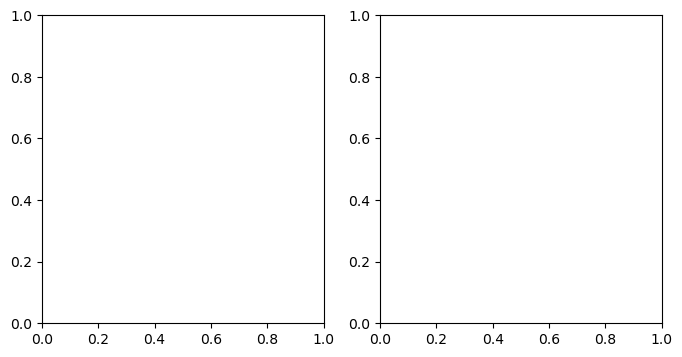

In [14]:
fig,axs = plt.subplots(1,2,figsize=(8,4))

pdf = stats.nbinom.pmf(np.round(x), n, p)
x = np.linspace(min(samples),max(samples))

axs[0].hist(counts,density=True,bins=100)
axs[0].plot(x,pdf)
axs[0].set_title('Observed Counts')
axs[1].hist(samples,density=True,bins=100)
axs[1].plot(x,pdf)
axs[1].set_title('Simulated Counts')

for ax in axs:
    ax.set_xlabel('Count')
    ax.set_ylabel('Density')
plt.tight_layout()

Now lets put this in a loop and calculate this for all the sites.

In [ ]:
def getNBSamples(mean,var,Nsamples=1000):
    p = mean / var
    n = mean * p / (1 - p)
    samples = stats.nbinom.rvs(n,p,size=Nsamples)
    return samples


In [ ]:
df_agg['Sampled'] = df_agg.apply(lambda row: getNBSamples(row['Mean_HourlyCount'], row['Variance_HourlyCount']), axis=1)

Lets look at the how this work in practice

In [ ]:
N = 10
location = 'Birrarung Marr'
mean_hourly_counts = df_agg[df_agg['LocationName'] == location]['Mean_HourlyCount'].values
repeated_counts = np.tile(mean_hourly_counts, N)

mean_hourly_counts = df_agg[df_agg['LocationName'] == location]['Mean_HourlyCount'].values
repeated_counts = np.tile(mean_hourly_counts, N)

# Extract the samples for each hour in the desired sequence
samples = df_agg[df_agg['LocationName'] == location]['Sampled'].tolist()
samples_sequence = [sample[i % len(sample)] for i in range(N) for sample in samples]

# Plot
plt.figure(figsize=(15, 6))
plt.plot(repeated_counts, label='Mean Hourly Count', color='blue')
plt.plot(samples_sequence, label='Samples', linestyle='--', color='red')

plt.legend()
plt.title(f'Mean Hourly Count and Samples for Location {location}')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [ ]:
samples.shape

We want to calculate the sMAPE

$ sMAPE = \frac{2}{n} \sum \frac{|F_t - A_t|}{|A_t| + |F_t|} \times 100 $

* $n$ is the number of data points.
* $F_t$ is the forecasted value at time 
* $A_t$ is the actual value at time 


In [ ]:
def sMAPE(y_true, y_pred):
    return 100 * (2.0 * abs(y_pred - y_true) / (abs(y_true) + abs(y_pred)))

In [ ]:
df_agg['sMAPE_cont'] = sMAPE(df_agg['Mean_HourlyCount'].values, df_agg['Sampled'] )
grouped = df_agg.groupby('LocationName').apply(lambda group: group['sMAPE_cont'].mean())

In [ ]:
df_agg.groupby('Hour')

In [ ]:
grouped


OK This didn't really work as I expected. There are a lot of hours which drive the 